In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
from poola import core as pool
import anchors

import core_functions as fns

gpp.set_aesthetics(palette='Set2')

In [3]:
def run_guide_residuals(lfc_df, paired_lfc_cols=[]):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Inputs:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    2. paired_lfc_cols: grouped list of initial populations and corresponding resistant populations 
    
    '''
    lfc_df = lfc_df.drop_duplicates()
    if not paired_lfc_cols:
        paired_lfc_cols = fns.pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots


def select_top_ranks(df, rank = 5): #pick top ranks from each column of df with ranks, rank = top rank threshold (e.g. 5 if top 5)
    '''
    Inputs: 
    1. df: Dataframe with columns "Gene Symbol" and data used to rank 
    2. rank: top number of rows to select 
    Outputs:
    1. final_top_rank_df: Data frame with top ranked rows 
    '''
    rank_cols = df.columns.to_list()[1:]
    prev_top_rank_rows = pd.DataFrame(columns = df.columns)
    final_top_rank_df = pd.DataFrame() #for final list
    for col in rank_cols:
        #top_rank_rows = df.copy().loc[lambda df: df[col] <= rank, :] #pick rows with rank <= 5
        top_rank_rows = df.copy().nlargest(rank, col)
        top_rank_df = pd.concat([prev_top_rank_rows, top_rank_rows]) #concat with rows selected from previous column
        prev_top_rank_rows = top_rank_df #set combined list as previous

    final_top_rank_df = prev_top_rank_rows.drop_duplicates(subset = ['Gene Symbol']) #drop duplicate gene rows
    return final_top_rank_df

## Data summary
 

In [8]:
reads_nopDNA = pd.read_csv('../../../Data/Reads/Goujon/Caco2/SecondaryScreens/counts-JD_GPP2845_Goujon_Plate3_CP1663.txt', sep='\t')
reads_nopDNA = reads_nopDNA.copy().drop('Construct IDs', axis=1)
CP1663_cols = ['Construct Barcode']+[col for col in reads_nopDNA.columns if 'CP1663' in col]
reads_nopDNA_CP1663 = reads_nopDNA[CP1663_cols]

reads_nopDNA_CP1663

pDNA_reads_all = pd.read_csv('../../../Data/Reads/Goujon/Calu3/Secondary_Library/counts-LS20210325_A01_AAHG03_XPR502_G0_CP1663_M-AM39.txt', sep='\t')
pDNA_reads = pDNA_reads_all[['Construct Barcode','A01_AAHG03_XPR502_G0_CP1663_M-AM39']].copy()
pDNA_reads = pDNA_reads.rename(columns = {'A01_AAHG03_XPR502_G0_CP1663_M-AM39': 'pDNA'})
pDNA_reads

reads_all = pd.merge(pDNA_reads, reads_nopDNA_CP1663, how = 'right', on='Construct Barcode')
empty_cols = [col for col in reads_all.columns if 'EMPTY' in col]
reads = reads_all.copy().drop(empty_cols, axis=1)

reads


,Construct Barcode,pDNA,Caco2-CP1663-initial population screen #1,Caco2-CP1663-resistant population screen #1,Caco2-CP1663-initial population screen #2,Caco2-CP1663-resistant population screen #2
0,AAAAAAAAAAAAAATTGGCC,11,616,477,1043,724
1,AAAAAAAAATTGGCCAGGCG,28,3582,3757,2143,2960
2,AAAAAAAGTTGTGCGAGCGA,45,4486,4264,4139,3937
3,AAAAAAGAAAATAAGTTCCC,28,2896,1934,1394,2063
4,AAAAAAGTTGTGCGAGCGAC,70,4678,3813,4298,2909
...,...,...,...,...,...,...
4996,TTTGGAGTGATATTCGAACA,51,5212,5101,5527,3864
4997,TTTGGCAGTCTATTACGGTA,62,5827,4700,5014,3701
4998,TTTGGTGTGGCCGTCGCGCA,30,2466,4628,2504,2799
4999,TTTGTGGGCCATTTAATTCA,52,9121,7063,7092,5698


In [10]:
# Gene Annotations
chip = pd.read_csv('../../../Data/Interim/Goujon/Secondary_Library/CP1663_GRCh38_NCBI_strict_gene_20210707.chip', sep='\t')
chip = chip.rename(columns={'Barcode Sequence':'Construct Barcode'})
chip_reads = pd.merge(chip[['Construct Barcode', 'Gene Symbol']], reads, on = ['Construct Barcode'], how = 'right')
chip_reads


,Construct Barcode,Gene Symbol,pDNA,Caco2-CP1663-initial population screen #1,Caco2-CP1663-resistant population screen #1,Caco2-CP1663-initial population screen #2,Caco2-CP1663-resistant population screen #2
0,AAAAAAAAAAAAAATTGGCC,IQCN,11,616,477,1043,724
1,AAAAAAAAAAAAAATTGGCC,LOC101929974,11,616,477,1043,724
2,AAAAAAAAATTGGCCAGGCG,IQCN,28,3582,3757,2143,2960
3,AAAAAAAGTTGTGCGAGCGA,GDI2,45,4486,4264,4139,3937
4,AAAAAAGAAAATAAGTTCCC,DBR1,28,2896,1934,1394,2063
...,...,...,...,...,...,...,...
5847,TTTGGAGTGATATTCGAACA,ONE_INTERGENIC_SITE_499,51,5212,5101,5527,3864
5848,TTTGGCAGTCTATTACGGTA,ONE_INTERGENIC_SITE_500,62,5827,4700,5014,3701
5849,TTTGGTGTGGCCGTCGCGCA,LYN,30,2466,4628,2504,2799
5850,TTTGTGGGCCATTTAATTCA,EEF1B2,52,9121,7063,7092,5698


In [11]:
#Calculate lognorm
cols = chip_reads.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(chip_reads.dropna(), cols = cols)
col_list = []

for col in lognorms.columns:
    if 'intitial'in col:
        new_col = col.replace('intitial', 'initial')
        col_list.append(new_col)
    else:
        col_list.append(col)

lognorms.columns = col_list
lognorms

,Construct Barcode,Gene Symbol,pDNA_lognorm,Caco2-CP1663-initial population screen #1_lognorm,Caco2-CP1663-resistant population screen #1_lognorm,Caco2-CP1663-initial population screen #2_lognorm,Caco2-CP1663-resistant population screen #2_lognorm
0,AAAAAAAAAAAAAATTGGCC,IQCN,5.731072,4.908095,4.832731,5.750846,5.602613
1,AAAAAAAAAAAAAATTGGCC,LOC101929974,5.731072,4.908095,4.832731,5.750846,5.602613
2,AAAAAAAAATTGGCCAGGCG,IQCN,7.062410,7.407512,7.765361,6.775920,7.611544
3,AAAAAAAGTTGTGCGAGCGA,GDI2,7.742824,7.730463,7.947199,7.719208,8.021212
4,AAAAAAGAAAATAAGTTCCC,DBR1,7.062410,7.102820,6.813604,6.162575,7.093895
...,...,...,...,...,...,...,...
5847,TTTGGAGTGATATTCGAACA,ONE_INTERGENIC_SITE_499,7.922604,7.945924,8.204812,8.134702,7.994315
5848,TTTGGCAGTCTATTACGGTA,ONE_INTERGENIC_SITE_500,8.203320,8.106223,8.087110,7.994693,7.932385
5849,TTTGGTGTGGCCGTCGCGCA,LYN,7.161226,6.872760,8.064920,6.998624,7.531283
5850,TTTGTGGGCCATTTAATTCA,EEF1B2,7.950504,8.750770,8.672954,8.493265,8.552854


## Quality Control
### Population Distributions

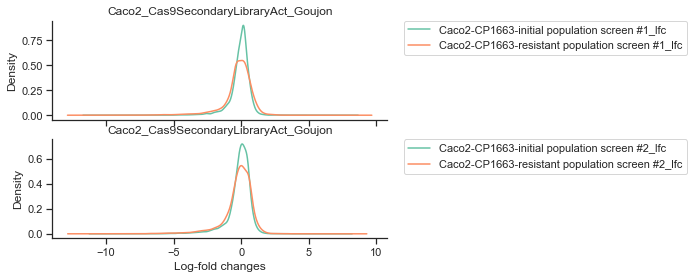

In [13]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)
pDNA_lfc
pair1 = list(pDNA_lfc.columns[2:4])
pair2 = list(pDNA_lfc.columns[-2:])
paired_cols = (True, [pair1, pair2])
#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, paired_cols=paired_cols, filename = 'Caco2_Cas9SecondaryLibraryAct_Goujon')


### Distributions of control sets 

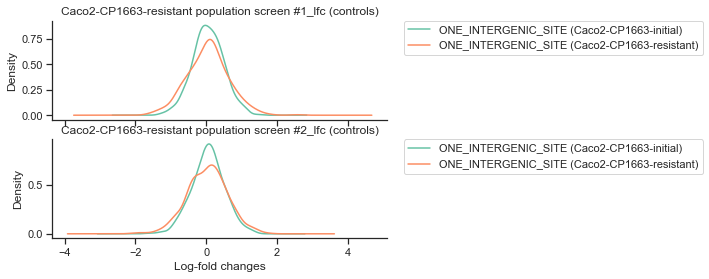

In [14]:
fns.control_dist_plot(pDNA_lfc, paired_cols=paired_cols, control_name=['ONE_INTERGENIC_SITE'], filename = 'Caco2_Cas9SecondaryLibraryAct_Goujon')


### ROC_AUC

Text(0, 0.5, 'True Positive Rate (essential)')

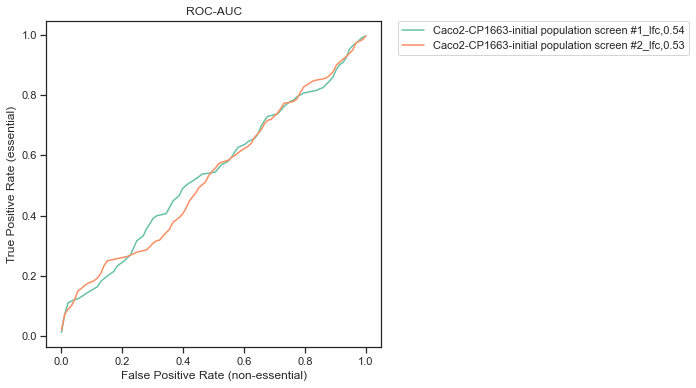

In [15]:
ess_genes, non_ess_genes = fns.get_gene_sets()
initial_cols = [col for col in pDNA_lfc.columns if 'initial' in col]

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

initial_roc_dict = {}
intial_roc_auc_dict = {}
for col in initial_cols:
    roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col=col)
    initial_roc_dict[col] = roc_df
    intial_roc_auc_dict[col] = roc_auc

fig,ax=plt.subplots(figsize=(6,6))

for key, df in initial_roc_dict.items():
    roc_auc = intial_roc_auc_dict[key]
    ax=sns.lineplot(data=df, x='fpr',y='tpr', ci=None, label = key+',' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene level analysis

### Residual z-scores

In [16]:
lfc_df = pDNA_lfc.drop('Gene Symbol', axis = 1)
lfc_df

,Construct Barcode,Caco2-CP1663-initial population screen #1_lfc,Caco2-CP1663-resistant population screen #1_lfc,Caco2-CP1663-initial population screen #2_lfc,Caco2-CP1663-resistant population screen #2_lfc
0,AAAAAAAAAAAAAATTGGCC,-0.822977,-0.898341,0.019774,-0.128459
1,AAAAAAAAAAAAAATTGGCC,-0.822977,-0.898341,0.019774,-0.128459
2,AAAAAAAAATTGGCCAGGCG,0.345103,0.702951,-0.286489,0.549135
3,AAAAAAAGTTGTGCGAGCGA,-0.012361,0.204374,-0.023616,0.278388
4,AAAAAAGAAAATAAGTTCCC,0.040411,-0.248805,-0.899834,0.031485
...,...,...,...,...,...
5847,TTTGGAGTGATATTCGAACA,0.023320,0.282208,0.212098,0.071711
5848,TTTGGCAGTCTATTACGGTA,-0.097097,-0.116210,-0.208627,-0.270935
5849,TTTGGTGTGGCCGTCGCGCA,-0.288465,0.903695,-0.162602,0.370057
5850,TTTGTGGGCCATTTAATTCA,0.800266,0.722450,0.542761,0.602350


In [17]:
# run_guide_residuals(lfc_df.drop_duplicates(), cols)
residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df, paired_lfc_cols=paired_cols[1])
residuals_lfcs


                                          modified  \
0  Caco2-CP1663-resistant population screen #1_lfc   
1  Caco2-CP1663-resistant population screen #2_lfc   

                                     unperturbed  
0  Caco2-CP1663-initial population screen #1_lfc  
1  Caco2-CP1663-initial population screen #2_lfc  


,Construct Barcode,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAAAAAAAATTGGCC,Caco2-CP1663-resistant population screen #1_lfc,0.308060,0.560628,Caco2-CP1663-initial population screen #1_lfc,-0.898341,-0.822977
1,AAAAAAAAATTGGCCAGGCG,Caco2-CP1663-resistant population screen #1_lfc,0.382607,0.696294,Caco2-CP1663-initial population screen #1_lfc,0.702951,0.345103
2,AAAAAAAGTTGTGCGAGCGA,Caco2-CP1663-resistant population screen #1_lfc,0.243884,0.443836,Caco2-CP1663-initial population screen #1_lfc,0.204374,-0.012361
3,AAAAAAGAAAATAAGTTCCC,Caco2-CP1663-resistant population screen #1_lfc,-0.269676,-0.490775,Caco2-CP1663-initial population screen #1_lfc,-0.248805,0.040411
4,AAAAAAGTTGTGCGAGCGAC,Caco2-CP1663-resistant population screen #1_lfc,0.188609,0.343243,Caco2-CP1663-initial population screen #1_lfc,-0.591238,-0.587200
...,...,...,...,...,...,...,...
9997,TTTGGAGTGATATTCGAACA,Caco2-CP1663-resistant population screen #2_lfc,-0.086819,-0.189098,Caco2-CP1663-initial population screen #2_lfc,0.071711,0.212098
9998,TTTGGCAGTCTATTACGGTA,Caco2-CP1663-resistant population screen #2_lfc,0.049142,0.107035,Caco2-CP1663-initial population screen #2_lfc,-0.270935,-0.208627
9999,TTTGGTGTGGCCGTCGCGCA,Caco2-CP1663-resistant population screen #2_lfc,0.637536,1.388600,Caco2-CP1663-initial population screen #2_lfc,0.370057,-0.162602
10000,TTTGTGGGCCATTTAATTCA,Caco2-CP1663-resistant population screen #2_lfc,0.070995,0.154631,Caco2-CP1663-initial population screen #2_lfc,0.602350,0.542761


In [18]:
guide_mapping = pool.group_pseudogenes(chip[['Construct Barcode', 'Gene Symbol']], pseudogene_size=10, gene_col='Gene Symbol', control_regex=['ONE_INTERGENIC_SITE'])
guide_mapping

,Construct Barcode,Gene Symbol
0,AAAAAAAAAAAAAATTGGCC,IQCN
1,AAAAAAAAAAAAAATTGGCC,LOC101929974
2,AAAAAAAAATTGGCCAGGCG,IQCN
3,AAAAAAAGTTGTGCGAGCGA,GDI2
4,AAAAAAGAAAATAAGTTCCC,DBR1
...,...,...
5847,TTTGGAGTGATATTCGAACA,ONE_INTERGENIC_SITE_10
5848,TTTGGCAGTCTATTACGGTA,ONE_INTERGENIC_SITE_43
5849,TTTGGTGTGGCCGTCGCGCA,LYN
5850,TTTGTGGGCCATTTAATTCA,EEF1B2


In [19]:
gene_residuals = anchors.get_gene_residuals(residuals_lfcs.drop_duplicates(), guide_mapping)
gene_residuals

,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Caco2-CP1663-resistant population screen #1_lfc,ABHD17B,1,0.521910,0.133256,0.755362,4.500315e-01,7.289830e-01
1,Caco2-CP1663-resistant population screen #1_lfc,ABRACL,10,0.036313,0.228341,-0.840604,4.005698e-01,6.783851e-01
2,Caco2-CP1663-resistant population screen #1_lfc,ACADSB,20,-0.246083,-0.201398,0.658725,5.100724e-01,7.788815e-01
3,Caco2-CP1663-resistant population screen #1_lfc,ACE,10,-0.035938,0.012697,0.106957,9.148234e-01,9.740343e-01
4,Caco2-CP1663-resistant population screen #1_lfc,ACE2,10,-2.460693,-0.035037,-13.575449,5.599941e-42,4.591952e-39
...,...,...,...,...,...,...,...,...
1635,Caco2-CP1663-resistant population screen #2_lfc,ZNF626,1,-0.324525,0.540530,-1.858713,6.306789e-02,6.861655e-01
1636,Caco2-CP1663-resistant population screen #2_lfc,ZNF703,10,-0.062014,0.118732,-0.777665,4.367663e-01,8.957944e-01
1637,Caco2-CP1663-resistant population screen #2_lfc,ZNF780A,10,-0.068189,0.142494,-0.996273,3.191176e-01,8.957944e-01
1638,Caco2-CP1663-resistant population screen #2_lfc,ZNF805,10,-0.146203,-0.024319,-0.225119,8.218868e-01,9.290102e-01


In [20]:
gene_residual_sheet = fns.format_gene_residuals(gene_residuals, guide_min = 8, guide_max = 11, ascending=True)

guide_residual_sheet = pd.merge(guide_mapping, residuals_lfcs.drop_duplicates(), on = 'Construct Barcode', how = 'inner')
guide_residual_sheet

['Caco2-CP1663-resistant population screen #2_lfc', 'Caco2-CP1663-resistant population screen #1_lfc']
Caco2-CP1663-resistant population screen #2_lfc
Caco2-CP1663-resistant population screen #1_lfc


,Construct Barcode,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAAAAAAAATTGGCC,IQCN,Caco2-CP1663-resistant population screen #1_lfc,0.308060,0.560628,Caco2-CP1663-initial population screen #1_lfc,-0.898341,-0.822977
1,AAAAAAAAAAAAAATTGGCC,IQCN,Caco2-CP1663-resistant population screen #2_lfc,-0.068820,-0.149896,Caco2-CP1663-initial population screen #2_lfc,-0.128459,0.019774
2,AAAAAAAAAAAAAATTGGCC,LOC101929974,Caco2-CP1663-resistant population screen #1_lfc,0.308060,0.560628,Caco2-CP1663-initial population screen #1_lfc,-0.898341,-0.822977
3,AAAAAAAAAAAAAATTGGCC,LOC101929974,Caco2-CP1663-resistant population screen #2_lfc,-0.068820,-0.149896,Caco2-CP1663-initial population screen #2_lfc,-0.128459,0.019774
4,AAAAAAAAATTGGCCAGGCG,IQCN,Caco2-CP1663-resistant population screen #1_lfc,0.382607,0.696294,Caco2-CP1663-initial population screen #1_lfc,0.702951,0.345103
...,...,...,...,...,...,...,...,...
11699,TTTGGTGTGGCCGTCGCGCA,LYN,Caco2-CP1663-resistant population screen #2_lfc,0.637536,1.388600,Caco2-CP1663-initial population screen #2_lfc,0.370057,-0.162602
11700,TTTGTGGGCCATTTAATTCA,EEF1B2,Caco2-CP1663-resistant population screen #1_lfc,-0.101049,-0.183895,Caco2-CP1663-initial population screen #1_lfc,0.722450,0.800266
11701,TTTGTGGGCCATTTAATTCA,EEF1B2,Caco2-CP1663-resistant population screen #2_lfc,0.070995,0.154631,Caco2-CP1663-initial population screen #2_lfc,0.602350,0.542761
11702,TTTGTTTAAATAGCACTACA,OR8K5,Caco2-CP1663-resistant population screen #1_lfc,-0.104420,-0.190031,Caco2-CP1663-initial population screen #1_lfc,-0.160139,-0.025013


In [21]:
with pd.ExcelWriter('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/Caco2_SecondaryLibraryAct_Goujon.xlsx') as writer:  
    gene_residual_sheet.to_excel(writer, sheet_name='Caco2_avg_zscore', index =False)
    reads.to_excel(writer, sheet_name='Caco2_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='Caco2_guide_mapping', index =False)

In [22]:
with pd.ExcelWriter('../../../Data/Processed/Individual_screens_v2/Caco2_SecondaryLibraryAct_Goujon.xlsx') as writer:  
    gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)

### Comparison to Secondary Library KO

Text(0, 0.5, 'Activation')

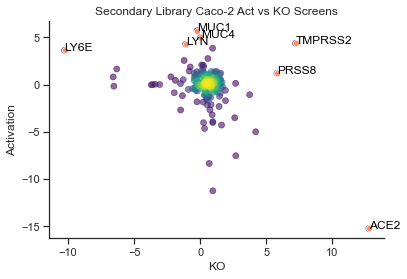

In [25]:
KO_gene_residual_sheet = pd.read_excel('../../../Data/Processed/GEO_submission_v2/SecondaryLibrary/Caco2_Cas9SecondaryLibraryKO_Goujon.xlsx')
secondary_library = pd.merge(KO_gene_residual_sheet, gene_residual_sheet, how = 'outer', on = 'Gene Symbol', suffixes=['_KO', '_Act'])

secondary_library

secondary_library_annot_df = select_top_ranks(secondary_library)
fig, ax = plt.subplots()
ax = gpp.point_densityplot(secondary_library.dropna(), x='residual_zscore_avg_KO', y='residual_zscore_avg_Act')
sns.scatterplot(data=secondary_library_annot_df.dropna(), x='residual_zscore_avg_KO', y='residual_zscore_avg_Act')
texts= []
for j, row in secondary_library_annot_df.dropna().iterrows():
    texts.append(ax.text(row['residual_zscore_avg_KO'], row['residual_zscore_avg_Act'], row['Gene Symbol'], 
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)
sns.despine()
plt.title('Secondary Library Caco-2 Act vs KO Screens')
plt.xlabel('KO')
plt.ylabel('Activation')
# fig.savefig('../../../Figures/SecondaryLibrary_Caco2_ActvsKO.png', bbox_inches='tight')


In [26]:
screen1_df = gene_residuals[gene_residuals['condition'].str.contains('#1')]
screen2_df = gene_residuals[gene_residuals['condition'].str.contains('#2')]
screen2_df_avg = screen2_df[['condition','Gene Symbol', 'residual_zscore']].groupby('Gene Symbol', as_index=False).mean()

zscore_df = pd.merge(screen1_df[['condition','Gene Symbol', 'residual_zscore']], screen2_df_avg, on = 'Gene Symbol', how = 'outer', suffixes = ['_screen#1', '_screen#2']).sort_values(by='residual_zscore_screen#1')
# zscore_df = pd.concat([screen1_df[['condition','Gene Symbol', 'residual_zscore']], screen2_df[['condition','Gene Symbol', 'residual_zscore']]])
zscore_df


,condition,Gene Symbol,residual_zscore_screen#1,residual_zscore_screen#2
4,Caco2-CP1663-resistant population screen #1_lfc,ACE2,-13.575449,-16.908539
186,Caco2-CP1663-resistant population screen #1_lfc,FOXD1,-10.577986,-11.942901
234,Caco2-CP1663-resistant population screen #1_lfc,HNF1B,-7.700928,-9.030959
602,Caco2-CP1663-resistant population screen #1_lfc,RBMS1,-7.554795,-2.460384
597,Caco2-CP1663-resistant population screen #1_lfc,RAI2,-7.376559,-8.641099
...,...,...,...,...
461,Caco2-CP1663-resistant population screen #1_lfc,MUC4,4.231765,5.781133
460,Caco2-CP1663-resistant population screen #1_lfc,MUC21,4.447555,3.237085
138,Caco2-CP1663-resistant population screen #1_lfc,DLX3,4.654975,0.484768
458,Caco2-CP1663-resistant population screen #1_lfc,MUC1,5.103399,6.286651


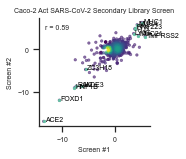

In [27]:
# Screen 2 vs Screen 1

fig, ax = plt.subplots(figsize = (2, 2))
ax = gpp.point_densityplot(zscore_df, 'residual_zscore_screen#1', 'residual_zscore_screen#2', s=6)
ax = gpp.add_correlation(zscore_df, 'residual_zscore_screen#1', 'residual_zscore_screen#2', fontsize=7)

top_ranked_screen1 = zscore_df.nsmallest(10, 'residual_zscore_screen#1')
top_ranked_screen2 = zscore_df.nsmallest(10, 'residual_zscore_screen#2')
bottom_ranked_screen1 = zscore_df.nlargest(10, 'residual_zscore_screen#1')
bottom_ranked_screen2 = zscore_df.nlargest(10, 'residual_zscore_screen#2')

screen1_ranked = pd.concat([top_ranked_screen1, bottom_ranked_screen1])
screen2_ranked = pd.concat([top_ranked_screen2, bottom_ranked_screen2])

# Annotate common hits
common_ranked = pd.merge(screen1_ranked, screen2_ranked, on = ['Gene Symbol', 'residual_zscore_screen#1', 'residual_zscore_screen#2'], how = 'inner')
common_ranked

sns.scatterplot(data=common_ranked, x='residual_zscore_screen#1', y='residual_zscore_screen#2', color = sns.color_palette('Set2')[0], edgecolor=None, s=6)

texts= []
for j, row in common_ranked.iterrows():
    texts.append(ax.text(row['residual_zscore_screen#1']+0.25, row['residual_zscore_screen#2'], row['Gene Symbol'], fontsize=7,
                                  color = 'black'))
        # ensures text labels are non-overlapping
#     adjust_text(texts)

plt.title('Caco-2 Act SARS-CoV-2 Secondary Library Screen', fontsize=7)
plt.xlabel('Screen #1', fontsize=7)
plt.ylabel('Screen #2', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
sns.despine()
gpp.savefig('../../../Figures/Scatterplots/Caco2_Act_Secondary_Screen1vs2_scatterplot.pdf', dpi=300)



In [28]:
with pd.ExcelWriter('../../../Data/Processed/Individual_screens_v2/Caco2_SecondaryLibraryAct_Goujon_indiv_screens.xlsx') as writer:  
    zscore_df.to_excel(writer, sheet_name='indiv_screen_zscore', index =False)
    gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)